In [1]:
import numpy as np
import cv2
import base64
import matplotlib.pyplot as plt

import tensorflow as tf

from json import loads,dumps
from tensorflow.keras.layers import *

In [2]:
def set_levels(network,input_nodes,level):
    for node in input_nodes:
        if network[node]['level'] > -1:            
            set_levels(network,network[node]['outbound'],network[node]['level']+1)
        else:
            network[node]['level'] = level
            if len(network[node]['outbound']):
                for ob in network[node]['outbound']:
                    network[ob]['level'] = level + 1
            set_levels(network,network[node]['outbound'],network[node]['level']+1)
        
def get_conf(model:tf.keras.models.Model,input_config:dict):
    model_conf = loads(model.to_json())
    network = {
        l['name']:{
            "inbound":[],
            "outbound":[],
            "class_name":l['class_name'],
            "level":-1,
        } for l in model_conf['config']['layers']
    }

    for l in model_conf['config']['layers']:
        if len(l['inbound_nodes']):
            for n in l['inbound_nodes'][0]:
                network[l['name']]['inbound'].append(n[0])
                network[n[0]]['outbound'].append(l['name'])

    set_levels(network,input_config['input_nodes'],0)
    levels = [[] for i in range(max([i['level'] for _,i in network.items()])+1)]
    for node,val in network.items():
        levels[val['level']].append(node)
    
    for i,level in enumerate(levels):
        if not len(level):
            j = i - 1
            while j:
                if len(levels[j]) > 1:
                    levels[i] = levels[j][1:]
                    levels[j] = levels[j][:1]
                    break
                j -= 1
                
    return network,levels

In [3]:
def image2base64(image:np.ndarray)->str:
    image = image.astype(np.uint8) if image.max() > 1 else (image * 255).astype(np.uint8)
    retval, buffer = cv2.imencode('.png', image)
    buffer = base64.b64encode(buffer)
    return 'data:image/png;base64,' + str(buffer,encoding="utf-8")

def prepare_input_image(image:np.ndarray,layer:dict,input_config:dict):
    try:
        image = image.reshape(input_config['shape'])
        image = cv2.resize(image,(128,128))
    except ValueError:
        _,*shape = layer['instance'].output_shape
        image = image.reshape(shape)
    if len(image.shape) == 3:
        return image2base64(image[:,:,::-1])
    return image2base64(image)

transformers = {
    "prepare_input_image":prepare_input_image
}

def prep_dummy(value:np.ndarray,layer:Layer,*args,**kwargs):
    pass

def prep_input_layer(
        value:np.ndarray,
        layer:dict,
        input_config:dict,
        *args,
        **kwargs
    )->list:
    """
    Prep Function For InputLayer 
    """
    func = transformers[input_config[layer['name']]['transformer']]
    return func(value.numpy(),layer,input_config[layer['name']])

def prep_dense(
        value:np.ndarray,
        *args,
        **kwargs
    )->list:
    """
    Prep Function For Dense Layer
    """
    (value,) = value.numpy()
    return ((value.astype(float) / value.max())).tolist()

def prep_activation(
        value:np.ndarray,
        layer:Layer,
        *args,
        **kwargs
    )->list:
    pass

def prep_lstm(value:np.ndarray,layer:tf.keras.layers.Layer,*args,**kwargs):
    if layer.return_sequences:
        value,*_ = value
        _min = value.min(axis=1).reshape(-1,1)
        _max = value.max(axis=1).reshape(-1,1)
        value = ((value - _min)/(_max - _min))
        value[np.isnan(value)] = 0
        return value.astype(float).tolist()
        
    return ((value / value.max())[0]).tolist()


def prep_conv2d(
        value:np.ndarray,
        *args,
        **kwargs
    )->list:
    """
    Prep function for Conv2D layer
    """
    value = value.numpy()
    _,h,w,c = value.shape
    images = value.reshape(c,h*w).copy()
    _min =  images.min(axis=1).reshape(-1,1)
    _max =  images.max(axis=1).reshape(-1,1)
    images = (((images - _min) / (_max - _min)).reshape(c,h,w)*255).astype(np.uint8)
    images[np.isnan(images)] = 0
    _max = images.max()
    _max = _max if _max else 1
    return [ (image2base64(image),float(image.mean()/_max)) for image in images ]

def get_outputs(
        tensor,
        layer,
        input_config,
        network,
        model
    ):
    func = prep_functions[layer['config']['class_name']]
    outputs = func(
        value=tensor,
        layer=layer,
        network=network,
        input_config=input_config,
        model=model
    )
    return outputs


def prep_ext_layer(
        value:np.ndarray,
        layer:dict,
        network:dict,
        input_config:dict,
        model,
        *args,**kwargs
    ):
    (parent,*_) = network[layer['name']]['inbound']
    layer = {
        "name":parent,
        "config":network[parent],
        "instance":layer['instance']
    }
    if network[parent]['class_name'] == 'InputLayer':
        return [get_outputs(value,layer,input_config,network,model)]
    return get_outputs(value,layer,input_config,network,model)

prep_functions = {
    "Conv2D":prep_conv2d,
    "Dense":prep_dense,
    "InputLayer":prep_input_layer,
    "MaxPooling2D":prep_conv2d,
    "Flatten":prep_dense,
    "LSTM":prep_lstm,
    
    "Concatenate":prep_ext_layer,
    "Activation":prep_ext_layer,
    "Add":prep_ext_layer,
    "BatchNormalization":prep_ext_layer,
    "ZeroPadding2D":prep_ext_layer
}

In [4]:
def set_output(model,network:dict,levels:list,input_values:dict,render_config:dict):
    temp_out = dict()
    inputs = None
    layer = None
    layer_instance = None
    layer_config = None
    
    for level in levels:
        for layer in level:
            layer_config = network[layer]
            layer_instance = model.get_layer(layer)
            inputs = None
            if len(layer_config['inbound']):
                if len(layer_config['inbound']) < 2:
                    inputs,*_ = [temp_out[i] for i in layer_config['inbound']]
                else:
                    inputs = [temp_out[i] for i in layer_config['inbound']]
                    
                out = layer_instance(inputs)
                temp_out[layer] = out
                network[layer]['outputs'] = get_outputs(
                    tensor=out,
                    layer={
                        "name":layer,
                        "config":layer_config,
                        "instance":layer_instance
                    },
                    input_config=render_config,
                    network=network,
                    model=model
                )
            else:
                inputs = input_values['inputs'][layer]
                out = layer_instance(inputs)
                temp_out[layer] = out
                func = prep_functions[layer_config['class_name']]
                network[layer]['outputs'] = func(
                    value=out,
                    layer ={
                        "name":layer,
                        "config":layer_config,
                        "instance":layer_instance
                    },
                    input_config = render_config,
                    network=network,
                    model=model
                )

In [6]:
from os import path as pathlib

model_path = pathlib.abspath("./saved_models/mushroom_classification/model.json")
weights_path = pathlib.abspath("./saved_models/mushroom_classification/model")

In [7]:
model = tf.keras.models.model_from_json(open(model_path,"r").read())

In [9]:
model.load_weights(weights_path)

In [20]:
def load_dataset(path):
    
    import pandas as pd
    from sklearn.model_selection import train_test_split
    
    df = pd.read_csv(path)
    X = df.copy()
    Y = X.pop("class")
    cols = []

    for i in X:
        col = df[i]
        if col.nunique() > 2:
            cols.append(pd.get_dummies(col,prefix=i))
        else:
            label,*_ = col.unique()
            col = (col == label).astype(np.uint8)
            cols.append(pd.DataFrame(col))

    X = pd.concat(cols,axis=1)
    
    return (list(X.columns),),train_test_split(X.values,Y.values)

In [21]:
(cols,),(X,x,Y,y) = load_dataset("./datasets/mushrooms.csv")

In [70]:
def input_function(x):
    return (x.reshape(1,784) / 255).astype(np.float32)

In [26]:
"""
example {
   inputs {
       node : value
       lables : value ( if any )
   } 
   output {
       node : value
   }
}
""";

In [72]:
input_config = {
    "examples":[
        {
            "name":f"ex_{i}_class_{str(y[i])}",
            "inputs":{
                "input":input_function(x[i]),
            },
            "outputs":{
                "out":y[i].__str__()
            }
        }
        
        for i in np.random.randint(0,len(x),20)
    ],
    "render_config":{
        "input":{
            "type":"image",
            "shape":(28,28),
            "transformer":"prepare_input_image",
            "resize":(128,128)
        }
    },
    "input_nodes":['input']
}

In [73]:
network,levels = get_conf(model,input_config)

In [74]:
set_output(
    model=model,
    network=network,
    levels=levels,
    input_values=input_config['examples'][0],
    render_config=input_config['render_config']
)

{'input': {'inbound': [],
  'outbound': ['dense_1'],
  'class_name': 'InputLayer',
  'level': 0,
  'outputs': ''},
 'dense_1': {'inbound': ['input'],
  'outbound': ['dense_2'],
  'class_name': 'Dense',
  'level': 1,
  'outputs': [0.0,
   0.0,
   0.685255344637602,
   0.2050772847848479,
   0.3533633786893125,
   0.0,
   0.0,
   0.0,
   0.4142526491248135,
   0.0,
   0.0,
   0.6493981311433833,
   0.36927138744791504,
   0.0,
   0.0,
   0.6123867900177915,
   0.08392135886359309,
   0.0,
   0.6641357721602353,
   0.0,
   0.0,
   0.0,
   0.15092284427219946,
   0.0,
   0.05352260411724807,
   0.0,
   0.0,
   0.30448366987794695,
   0.0,
   0.0,
   0.18790183475238498,
   0.194992219432225,
   1.0,
   0.0,
   0.0,
   0.017736175206517192,
   0.0,
   0.586400194674004,
   0.0,
   0.283299914411163,
   0.0,
   0.0,
   0.5737750205679271,
   0.4572175887997142,
   0.5627261305794713,
   0.0,
   0.0,
   0.2019183457616249,
   0.49977700082479026,
   0.0,
   0.1470015378866226,
   0.0,
   0.0,
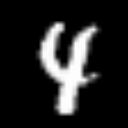

In [75]:
network